In [39]:
# Importing Libraries..
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from collections import Counter

# packages from gensim
#!pip install gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# packages from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#packages from nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

import nltk
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score,precision_score, recall_score, classification_report,roc_auc_score,roc_curve,auc
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, cross_val_predict

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the training data..
train=pd.read_csv('mccp_train.csv')
train.head()

id                                       comment_text  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   

   malignant  highly_malignant  rude  threat  abuse  loathe  
0          0                 0     0       0      0       0  
1          0                 0     0       0      0       0  
2          0                 0     0       0      0       0  
3          0                 0     0       0      0       0  
4          0                 0     0       0      0       0

In [3]:
# Loading the test data..
test=pd.read_csv('mccp_test.csv')
test.head()

id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.

In [4]:
# checking the features, records and target columns og train datdset
print('%d features and %d records.' % (train.shape[1], train.shape[0]))
print()
targets = list(train.columns[2:])
print('Target columns: ' + ', '.join(targets))

8 features and 159571 records.

Target columns: malignant, highly_malignant, rude, threat, abuse, loathe


In [5]:
# checking the features, records and target columns og train datdset
print('%d features and %d records.' % (test.shape[1], test.shape[0]))
print()
targets = list(test.columns[2:])
print('Target columns: ' + ', '.join(targets))

2 features and 153164 records.

Target columns: 


In [6]:
#finding null values in the database
print("Train Database null  values ")
print("    ")
print(train.isnull().sum())
print("    ")
print("Test Database null  values ")
print("    ")
print(test.isnull().sum())

Train Database null  values 
    
id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64
    
Test Database null  values 
    
id              0
comment_text    0
dtype: int64


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
# Checking value counts for each feature..
features=['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe',]
for i in features:
    print("Number of value_counts of {} : {}".format(i, train[i].nunique()))
    print(train[f'{i}'].value_counts())

Number of value_counts of malignant : 2
0    144277
1     15294
Name: malignant, dtype: int64
Number of value_counts of highly_malignant : 2
0    157976
1      1595
Name: highly_malignant, dtype: int64
Number of value_counts of rude : 2
0    151122
1      8449
Name: rude, dtype: int64
Number of value_counts of threat : 2
0    159093
1       478
Name: threat, dtype: int64
Number of value_counts of abuse : 2
0    151694
1      7877
Name: abuse, dtype: int64
Number of value_counts of loathe : 2
0    158166
1      1405
Name: loathe, dtype: int64


In [9]:
# Dropping features which are not giving any useful information
train.drop(['id'],axis=1,inplace=True)

In [10]:
# Statistical chart
train.describe()

malignant  highly_malignant           rude         threat  \
count  159571.000000     159571.000000  159571.000000  159571.000000   
mean        0.095844          0.009996       0.052948       0.002996   
std         0.294379          0.099477       0.223931       0.054650   
min         0.000000          0.000000       0.000000       0.000000   
25%         0.000000          0.000000       0.000000       0.000000   
50%         0.000000          0.000000       0.000000       0.000000   
75%         0.000000          0.000000       0.000000       0.000000   
max         1.000000          1.000000       1.000000       1.000000   

               abuse         loathe  
count  159571.000000  159571.000000  
mean        0.049364       0.008805  
std         0.216627       0.093420  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000

                  malignant  highly_malignant      rude    threat     abuse  \
malignant          1.000000          0.308619  0.676515  0.157058  0.647518   
highly_malignant   0.308619          1.000000  0.403014  0.123601  0.375807   
rude               0.676515          0.403014  1.000000  0.141179  0.741272   
threat             0.157058          0.123601  0.141179  1.000000  0.150022   
abuse              0.647518          0.375807  0.741272  0.150022  1.000000   
loathe             0.266009          0.201600  0.286867  0.115128  0.337736   

                    loathe  
malignant         0.266009  
highly_malignant  0.201600  
rude              0.286867  
threat            0.115128  
abuse             0.337736  
loathe            1.000000  
AxesSubplot(0.125,0.125;0.62x0.755)


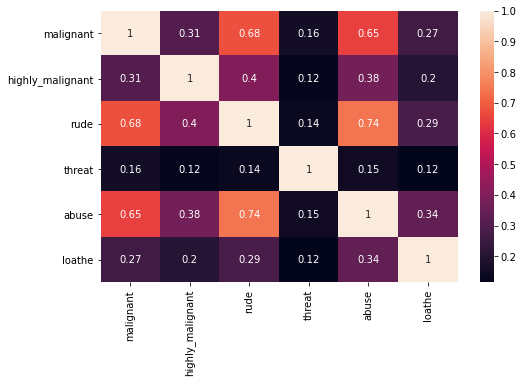

In [11]:
##  correlation chart
print(train.corr())
plt.figure(figsize=(8,5))
print(sns.heatmap(train.corr(),annot=True))

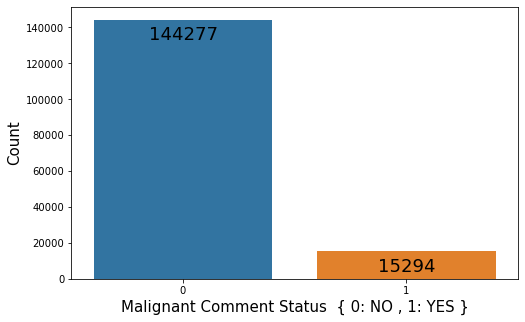

In [12]:
# countplot of  Malignant  comments Status . 
plt.figure(figsize=(8,5))
pd =sns.countplot(x = "malignant" ,  data=train)
for p in pd.patches:
    pd.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=18,
                   xytext = (0, -15), 
                   textcoords = 'offset points')
plt.xlabel("Malignant Comment Status  { 0: NO , 1: YES }", size=15)
plt.ylabel("Count" ,size=15)
plt.show()

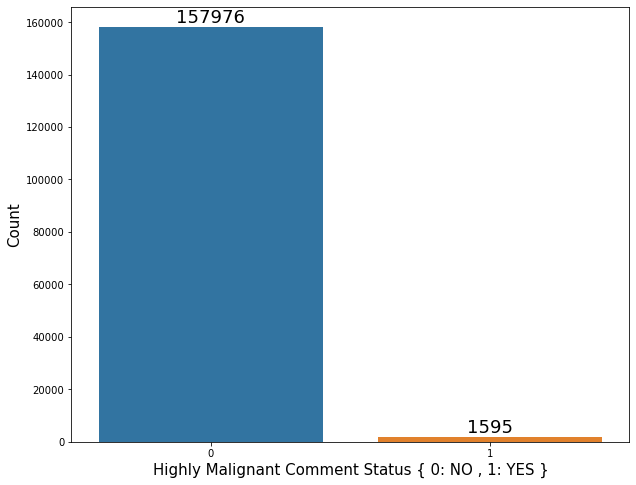

In [13]:
# countplot of Highly Malignant comments status . 
plt.figure(figsize=(10,8))
pd =sns.countplot(x = "highly_malignant" ,  data=train)
for p in pd.patches:
    pd.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=18,
                   xytext = (0, +10), 
                   textcoords = 'offset points')
plt.xlabel("Highly Malignant Comment Status { 0: NO , 1: YES }", size=15)
plt.ylabel("Count" ,size=15)
plt.show()

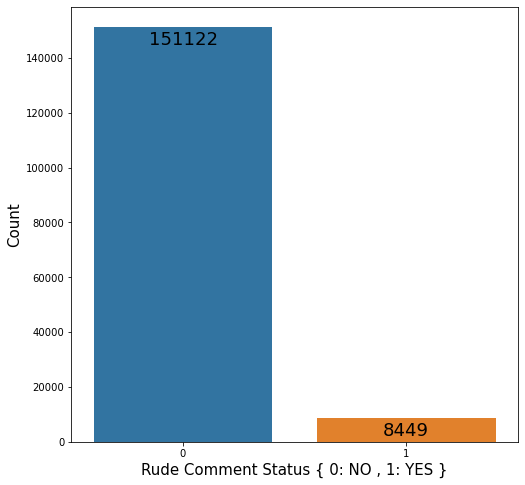

In [14]:
# countplot of Rude comment Status . 
plt.figure(figsize=(8,8))
pd =sns.countplot(x = "rude" ,  data=train)
for p in pd.patches:
    pd.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=18,
                   xytext = (0, -12), 
                   textcoords = 'offset points')
plt.xlabel("Rude Comment Status { 0: NO , 1: YES }", size=15)
plt.ylabel("Count" ,size=15)
plt.show()

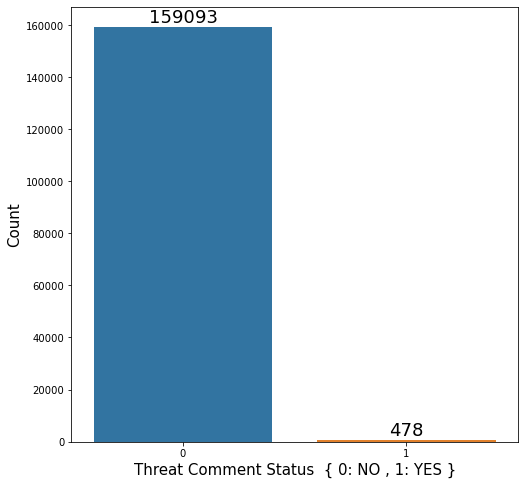

In [15]:
# countplot of Threat Comments Status  . 
plt.figure(figsize=(8,8))
pd =sns.countplot(x = "threat" ,  data=train)
for p in pd.patches:
    pd.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=18,
                   xytext = (0, 10), 
                   textcoords = 'offset points')
plt.xlabel("Threat Comment Status  { 0: NO , 1: YES }", size=15)
plt.ylabel("Count" ,size=15)
plt.show()

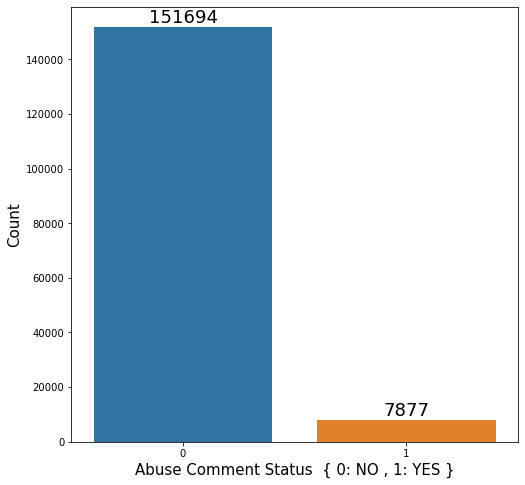

In [16]:
# countplot of  Abuse Comment Status  . 
plt.figure(figsize=(8,8))
pd =sns.countplot(x = "abuse" ,  data=train)
for p in pd.patches:
    pd.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=18,
                   xytext = (0, 10), 
                   textcoords = 'offset points')
plt.xlabel("Abuse Comment Status  { 0: NO , 1: YES }", size=15)
plt.ylabel("Count" ,size=15)
plt.show()

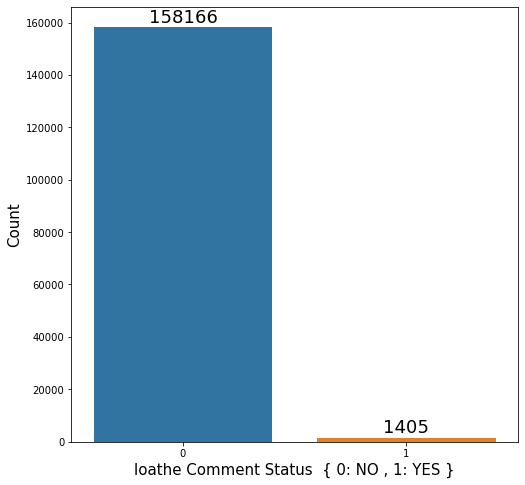

In [17]:
# countplot of loathe Comment Status  . 
plt.figure(figsize=(8,8))
pd =sns.countplot(x = "loathe" ,  data=train)
for p in pd.patches:
    pd.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=18,
                   xytext = (0, 10), 
                   textcoords = 'offset points')
plt.xlabel("loathe Comment Status  { 0: NO , 1: YES }", size=15)
plt.ylabel("Count" ,size=15)
plt.show()

In [18]:
# New feature (length) contains length of the  features
train['length']=train.comment_text.str.len()
train

comment_text  malignant  \
0       Explanation\nWhy the edits made under my usern...          0   
1       D'aww! He matches this background colour I'm s...          0   
2       Hey man, I'm really not trying to edit war. It...          0   
3       "\nMore\nI can't make any real suggestions on ...          0   
4       You, sir, are my hero. Any chance you remember...          0   
...                                                   ...        ...   
159566  ":::::And for the second time of asking, when ...          0   
159567  You should be ashamed of yourself \n\nThat is ...          0   
159568  Spitzer \n\nUmm, theres no actual article for ...          0   
159569  And it looks like it was actually you who put ...          0   
159570  "\nAnd ... I really don't think you understand...          0   

        highly_malignant  rude  threat  abuse  loathe  length  
0                      0     0       0      0       0     264  
1                      0     0       0      0       0     112  
2                      0     0       0      0       0     233  
3                      0     0       0      0       0     622  
4                      0     0       0      0       0      67  
...                  ...   ...     ...    ...     ...     ...  
159566                 0     0       0      0       0     295  
159567                 0     0       0      0       0      99  
159568                 0     0       0      0       0      81  
159569                 0     0       0      0       0     116  
159570                 0     0       0      0       0     189  

[159571 rows x 8 columns]

# Data Cleaning

In [19]:
# Replace email address with 'email'
train['comment_text']=train['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

#ReplaceURLs with 'webaddress'
train['comment_text']=train['comment_text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

#Replace money symbols with 'moneysymb'
train['comment_text']=train['comment_text'].str.replace(r'£|\$','dollars')

#Replace 10 digit phone number 
train['comment_text']=train['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
                                                
#Replace numbers with 'numbr'
train['comment_text']=train['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove Punctuation 
train['comment_text']=train['comment_text'].str.replace(r'[^\w\d\s]',' ')

#Replace Whitspace between terms with  a single space
train['comment_text']=train['comment_text'].str.replace(r'\s+',' ')

#Remove leading and trailing whitespace
train['comment_text']=train['comment_text'].str.replace(r'^\s+|\s+?$',' ')

In [20]:
# Replace email address with 'email'
test['comment_text']=test['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

#ReplaceURLs with 'webaddress'
test['comment_text']=test['comment_text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

#Replace money symbols with 'moneysymb'
test['comment_text']=test['comment_text'].str.replace(r'£|\$','dollars')

#Replace 10 digit phone number 
test['comment_text']=test['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
                                                
#Replace numbers with 'numbr'
test['comment_text']=test['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove Punctuation 
test['comment_text']=test['comment_text'].str.replace(r'[^\w\d\s]',' ')

#Replace Whitspace between terms with  a single space
test['comment_text']=test['comment_text'].str.replace(r'\s+',' ')

#Remove leading and trailing whitespace
test['comment_text']=test['comment_text'].str.replace(r'^\s+|\s+?$',' ')

In [21]:
#Removing Stopwords from train data

stop_words = set(stopwords.words('english') +['u','ur','4','2','im','dont','doin'])
train['comment_text'] = train['comment_text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [22]:
#Remove Stopwords from test data

stop_words = set(stopwords.words('english') +['u','ur','4','2','im','dont','doin'])
test['comment_text'] = test['comment_text'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [23]:
# checking the clean comments content..
train["comment_text"]

0         Explanation Why edits made username Hardcore M...
1         D aww He matches background colour I seemingly...
2         Hey man I really trying edit war It guy consta...
3         More I make real suggestions improvement I won...
4                     You sir hero Any chance remember page
                                ...                        
159566    And second time asking view completely contrad...
159567    You ashamed That horrible thing put talk page ...
159568    Spitzer Umm theres actual article prostitution...
159569    And looks like actually put speedy first versi...
159570    And I really think understand I came idea bad ...
Name: comment_text, Length: 159571, dtype: object

In [24]:
# New feature (Clean_length) contains length of the clean_comment_text feature after puncuations, stopwords removal..
train['Clean_length'] = train.comment_text.str.len()
train.head()

comment_text  malignant  \
0  Explanation Why edits made username Hardcore M...          0   
1  D aww He matches background colour I seemingly...          0   
2  Hey man I really trying edit war It guy consta...          0   
3  More I make real suggestions improvement I won...          0   
4              You sir hero Any chance remember page          0   

   highly_malignant  rude  threat  abuse  loathe  length  Clean_length  
0                 0     0       0      0       0     264           187  
1                 0     0       0      0       0     112           100  
2                 0     0       0      0       0     233           149  
3                 0     0       0      0       0     622           398  
4                 0     0       0      0       0      67            37

In [25]:
# New Column (clean_length) after puncuation ,stopwords removal

train['clean_length'] = train.comment_text.str.len()

#Total Length removal
print('Original Length' , train.length.sum())
print('Clean Length',  train.clean_length.sum() )

Original Length 62893130
Clean Length 42615013


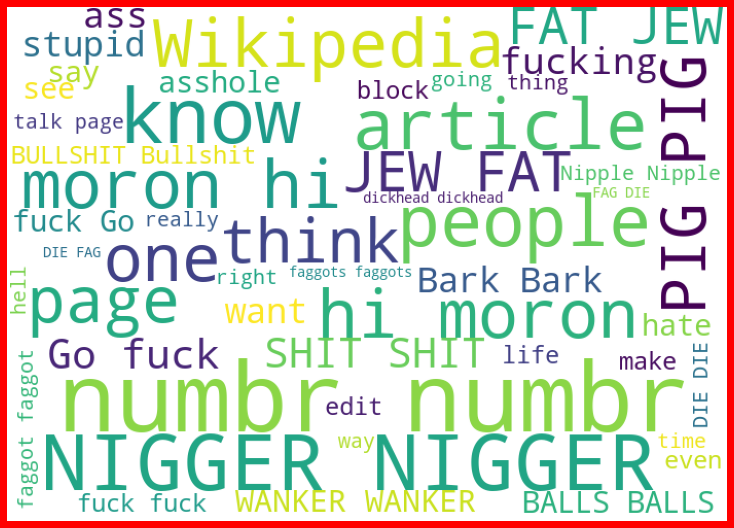

In [26]:
#getting sense of loud words in Comments which are  marked as Malignant

from wordcloud import WordCloud

sp = train['comment_text'][train['malignant']==1]
sp_cloud =WordCloud(width=700, height = 500, background_color='white', max_words=50).generate(' '.join(sp))
plt.figure(figsize=(10,8),facecolor ='r')
plt.imshow(sp_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

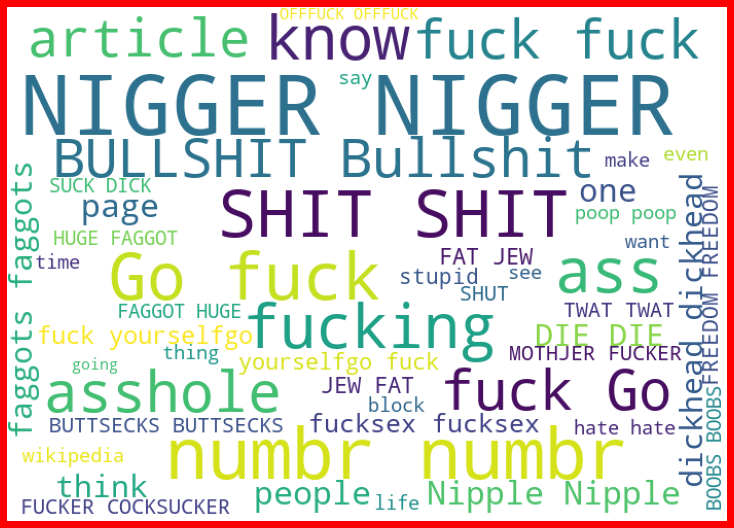

In [27]:
#getting sense of loud words in Comments which are marked as rude.

from wordcloud import WordCloud

sp = train['comment_text'][train['rude']==1]
sp_cloud =WordCloud(width=700, height = 500, background_color='white', max_words=50).generate(' '.join(sp))
plt.figure(figsize=(10,8),facecolor ='r')
plt.imshow(sp_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

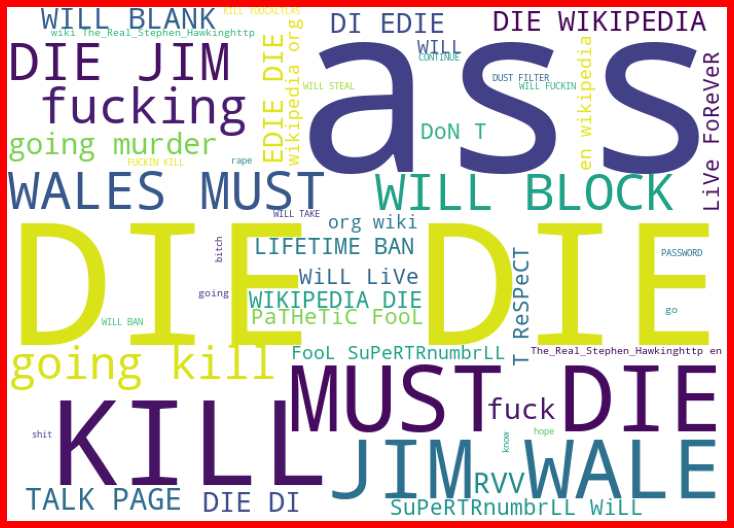

In [28]:
#getting sense of loud words in Comments which are marked as threat.

from wordcloud import WordCloud

sp = train['comment_text'][train['threat']==1]
sp_cloud =WordCloud(width=700, height = 500, background_color='white', max_words=50).generate(' '.join(sp))
plt.figure(figsize=(10,8),facecolor ='r')
plt.imshow(sp_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

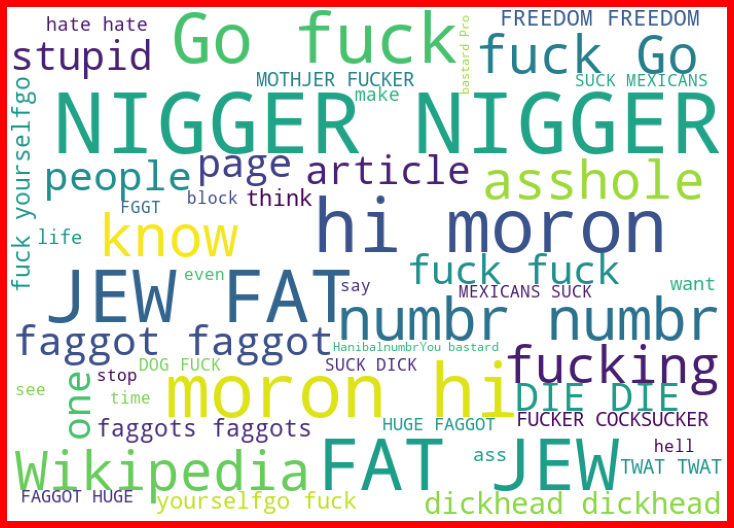

In [29]:
#getting sense of loud words in Comments which are marked as abuse.

from wordcloud import WordCloud

sp = train['comment_text'][train['abuse']==1]
sp_cloud =WordCloud(width=700, height = 500, background_color='white', max_words=50).generate(' '.join(sp))
plt.figure(figsize=(10,8),facecolor ='r')
plt.imshow(sp_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

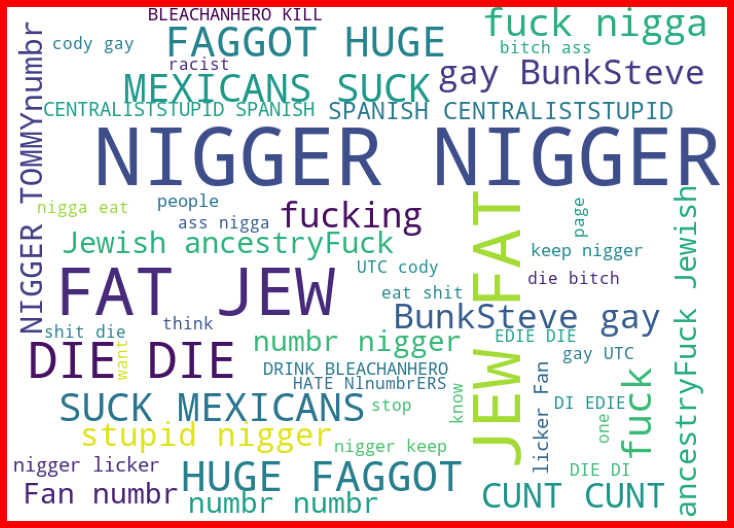

In [30]:
#getting sense of loud words in Comments which are marked as loathe.

from wordcloud import WordCloud

sp = train['comment_text'][train['loathe']==1]
sp_cloud =WordCloud(width=700, height = 500, background_color='white', max_words=50).generate(' '.join(sp))
plt.figure(figsize=(10,8),facecolor ='r')
plt.imshow(sp_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

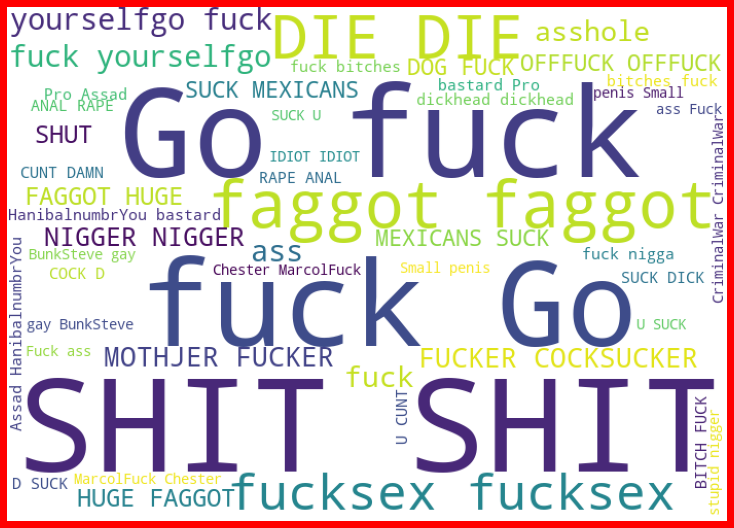

In [31]:
#getting sense of loud words in Comments which are marked as highly_malignant.

from wordcloud import WordCloud

sp = train['comment_text'][train['highly_malignant']==1]
sp_cloud =WordCloud(width=700, height = 500, background_color='white', max_words=50).generate(' '.join(sp))
plt.figure(figsize=(10,8),facecolor ='r')
plt.imshow(sp_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

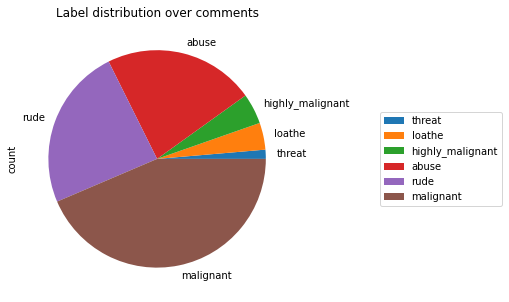

In [32]:
cols_target = ['malignant','threat','abuse','loathe','highly_malignant','rude',]
df_distribution = train[cols_target].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.plot.pie(y='count',
                                      title='Label distribution over comments',
                                      figsize=(8, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [33]:
target_data = train[cols_target]

train['label'] =train[cols_target].sum(axis =1)
print(train['label'].value_counts())
train['label'] = train['label'] > 0 
train['label'] = train['label'].astype(int)
print(train['label'].value_counts())

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: label, dtype: int64
0    143346
1     16225
Name: label, dtype: int64


In [40]:
df = pd.DataFrame()

In [41]:
#for counting frequently occurence of Malignant and not Malignant words.
count1 = Counter(" ".join(train[train['label']==0]["comment_text"]).split()).most_common(200)
count2 = Counter(" ".join(train[train['label']==1]["comment_text"]).split()).most_common(200)
print("TOP 200 Words in Each Category (Word,Counts)")
df['Malignant Words']=count1
df['Not Malignant Words']=count2
df.head(10)

TOP 200 Words in Each Category (Word,Counts)


Malignant Words Not Malignant Words
0         (I, 203214)          (I, 21244)
1     (numbr, 147123)       (numbr, 9383)
2    (article, 54583)         (YOU, 8664)
3       (page, 42848)         (You, 6816)
4        (The, 41501)        (fuck, 4910)
5  (Wikipedia, 37384)        (FUCK, 3533)
6      (would, 27183)        (like, 3512)
7       (talk, 26643)           (A, 3064)
8        (one, 25181)      (NIGGER, 2428)
9         (If, 25102)        (SUCK, 2393)

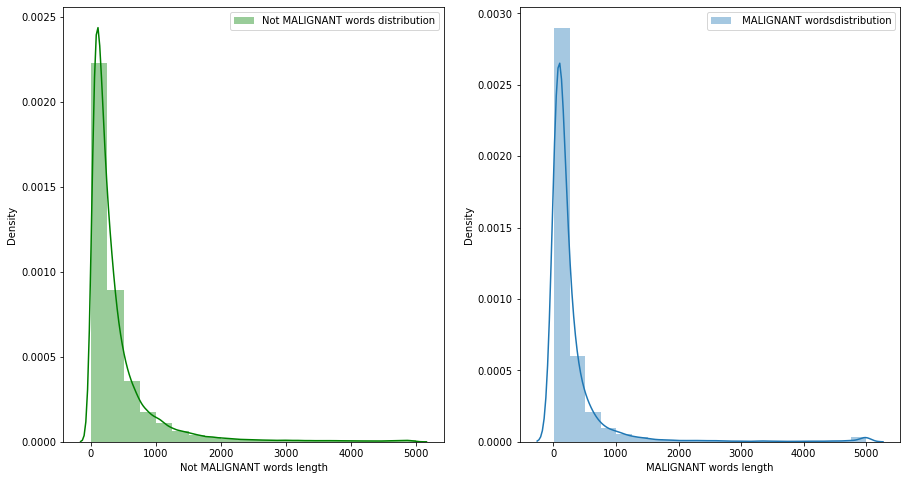

In [42]:
# Comments length distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(train[train['label']==0]['length'],bins=20,ax=ax[0],label='Not MALIGNANT words distribution',color='g')

ax[0].set_xlabel('Not MALIGNANT words length')
ax[0].legend()

sns.distplot(train[train['label']==1]['length'],bins=20,ax=ax[1],label=' MALIGNANT wordsdistribution')
ax[1].set_xlabel('MALIGNANT words length')
ax[1].legend()

plt.show()

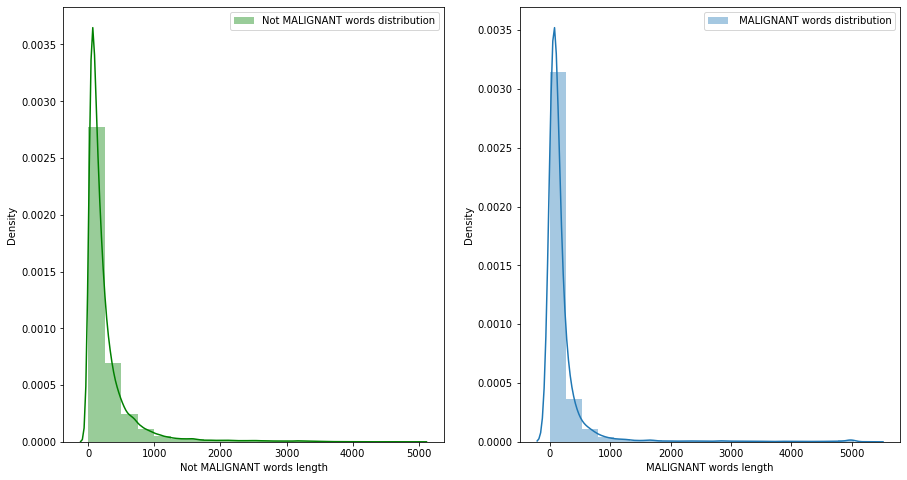

In [43]:
# Comments length distribution after cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(train[train['label']==0]['Clean_length'],bins=20,ax=ax[0],label='Not MALIGNANT words distribution',color='g')

ax[0].set_xlabel('Not MALIGNANT words length')
ax[0].legend()

sns.distplot(train[train['label']==1]['Clean_length'],bins=20,ax=ax[1],label=' MALIGNANT words distribution')
ax[1].set_xlabel('MALIGNANT words length')
ax[1].legend()

plt.show()

# Convert Train Data into Vectors


In [44]:
# creating the TF-IDF(term frequency–inverse document frequency) vectorizer function in order to convert the tokens 
#   from the train documents into vectors so that machine can do further processing
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)

In [45]:
# Inserting vectorized values in a variable x, which will be used in training the model 
x=Tf_idf_train(train['comment_text'])

In [46]:
# checking the shape of the data which is inserted in x which will be used for model training.
print("Shape of x: ",x.shape)

# Assigning the label in y and checking it's shape
y = train['label'].values
print("Shape of y: ",y.shape)

Shape of x:  (159571, 51306)
Shape of y:  (159571,)


In [47]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state= 42 ,test_size=0.30)

In [48]:
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score > max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state



The model calculation for LogisticRegression() are:
[0 0 0 ... 0 0 0]
Accuracy Score=  0.9549005681818182
The CV Score is 0.9557501059045267

[[42791  1945]
 [  214  2922]]

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     44736
           1       0.60      0.93      0.73      3136

    accuracy                           0.95     47872
   macro avg       0.80      0.94      0.85     47872
weighted avg       0.97      0.95      0.96     47872



F1 Score=  0.7302261651880545

Log loss :  1.5577116780918683

Precision Score=  0.6003698376823505

Recall Score=  0.9317602040816326

roc_auc_score 0.7976968360601032


AxesSubplot(0.125,0.808774;0.62x0.0712264)


The model calculation for KNeighborsClassifier() are:
[0 0 0 ... 1 0 0]
Accuracy Score=  0.8434366644385026
The CV Score is 0.8615224031850207

[[39173  3663]
 [ 3832  1204]]

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     

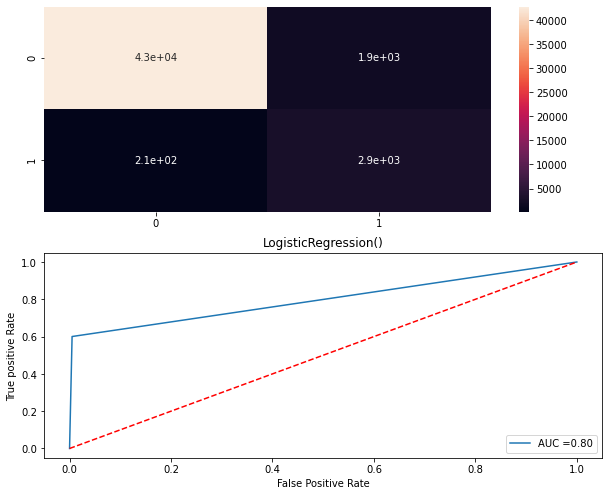

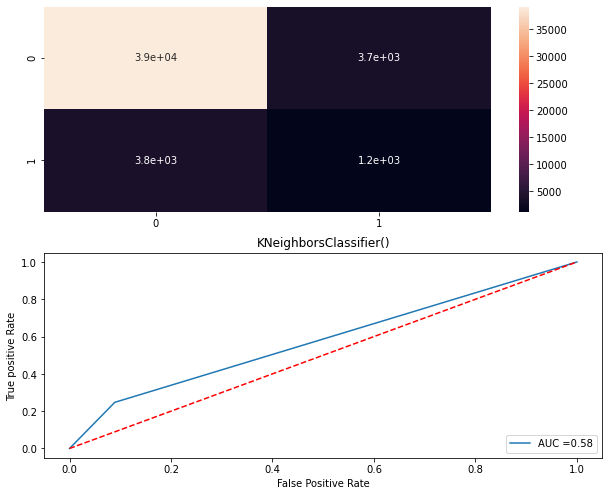

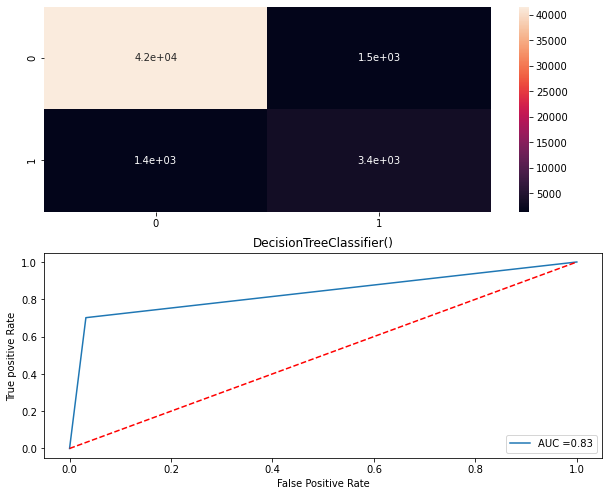

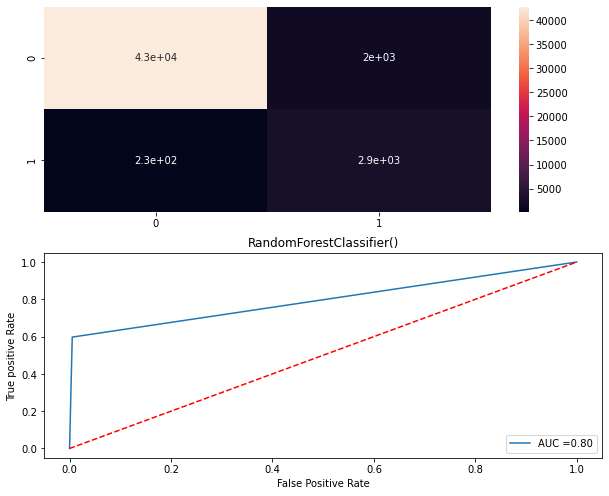

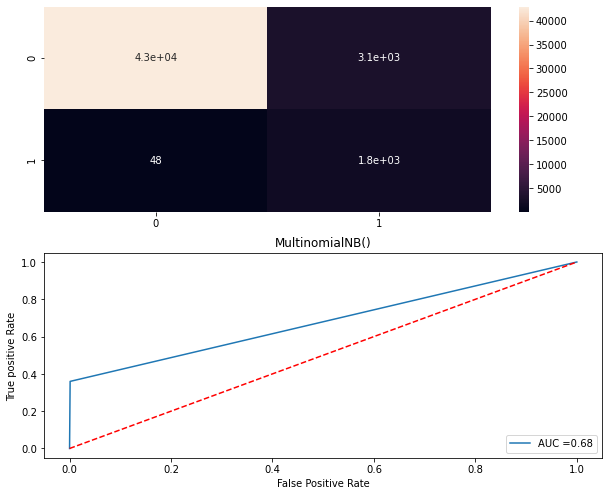

In [49]:
model=[]
score=[]
cvs=[]
rocscore=[]
F1score=[]
Precisionscore=[]
Recallscore=[]
lg_loss=[]

for i in [LogisticRegression(),
          KNeighborsClassifier() ,
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          MultinomialNB()]:
          
    
          
          
        k=i
        model.append(i)
        print("\n")
        print("The model calculation for" ,i,"are:" )
        k.fit(x_train,y_train)
        k.score(x_train,y_train)
        predict =k.predict(x_test)
        print(predict)
        #-----------Acurracy Score ------------------------------------
        AS=accuracy_score(predict,y_test)
        print("Accuracy Score= " ,AS)
        score.append(AS)
        #-------------Finding Cross Value Score------------------------
        cv_score=cross_val_score(k,x,y,cv=5,scoring="accuracy").mean()
        print("The CV Score is"  ,cv_score)
        cvs.append(cv_score)
        print("")
        #---------------------Confusion Matrix-------------------------
        cm=confusion_matrix(predict,y_test)
        print(cm)
        print("")
        print(classification_report(predict,y_test))
        print("\n")
        #-----------------F1 Score------------------------------------
        F1=f1_score(predict,y_test)
        print("F1 Score= " ,F1)
        F1score.append(F1)
        print("")
        #-----------------Log loss------------------------------------
        loss = log_loss(predict,y_test)
        print('Log loss : ', loss)
        lg_loss.append(loss)
        print("")
        #---------------Precision Score-------------------------------
        precision=precision_score(predict,y_test)
        print("Precision Score= " ,precision)
        Precisionscore.append(precision)
        print("")
        #-----------Recall Score ------------------------------------
        rec=recall_score(predict,y_test)
        print("Recall Score= " ,rec)
        Recallscore.append(rec)
        print("")
        #---------------Roc Auc Score
        false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test,predict)
        roc_auc=auc(false_positive_rate,true_positive_rate)
        print("roc_auc_score" ,roc_auc)
        rocscore.append(roc_auc)
        print("\n")
        plt.figure(figsize=(10,40))
        plt.subplot(911)
        print(sns.heatmap(cm,annot=True))
        plt.subplot(912)
        plt.title(i)
        plt.plot(false_positive_rate,true_positive_rate,label="AUC =%0.2f" %roc_auc)
        plt.plot([0,1] ,[0,1] ,'r--')
        plt.legend(loc="lower right")
        plt.ylabel('True positive Rate')
        plt.xlabel("False Positive Rate")

In [50]:
result=pd.DataFrame({'Model':['LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier','MultinomialNB'],'Accuracy_Score':score,'Cross_val_score':cvs,'Log_loss':lg_loss,'Roc_auc_curve':rocscore,'F1_Score':F1score,'Precison_Score':Precisionscore,'Recall_Score':Recallscore})
result

Model  Accuracy_Score  Cross_val_score  Log_loss  \
0      LogisticRegression        0.954901         0.955750  1.557712   
1    KNeighborsClassifier        0.843437         0.861522  5.407567   
2  DecisionTreeClassifier        0.940738         0.941186  2.046868   
3  RandomForestClassifier        0.954316         0.954447  1.577913   
4           MultinomialNB        0.933907         0.936223  2.282820   

   Roc_auc_curve  F1_Score  Precison_Score  Recall_Score  
0       0.797697  0.730226        0.600370      0.931760  
1       0.579137  0.243159        0.247380      0.239079  
2       0.834638  0.706467        0.701459      0.711546  
3       0.796005  0.726659        0.597288      0.927569  
4       0.679327  0.525353        0.359770      0.973319

# From the above analysis w.r.t Accuracy score, Cross value score and F1 score Random Forest Classifier is performing best

In [57]:
rfc=RandomForestClassifier()
rfc.fit(x_train,y_train)
predict=rfc.predict(x_test)
AS=accuracy_score(predict,y_test)
print("Accuracy Score=" ,AS)
cv_score=cross_val_score(rfc,x,y,cv=5,scoring="accuracy").mean()
print("The CV Score is", cv_score)
loss = log_loss(predict,y_test)
print("Log loss is", loss)
cm=confusion_matrix(predict,y_test)
print("Confusion matrix ", cm)

Accuracy Score= 0.9547752339572193
The CV Score is 0.9542836762330802
Log loss is 1.5620404185245347
Confusion matrix  [[42776  1936]
 [  229  2931]]


# Converting Test Data into Vectors


In [58]:
def Tf_idf_test(text):
    tfid = TfidfVectorizer(max_features= 51306,smooth_idf=False)
    return tfid.fit_transform(text)

In [59]:
tf_vec= TfidfVectorizer(max_features = 51306  ,stop_words = 'english')
features1 =tf_vec.fit_transform(test['comment_text'])

In [60]:

prediction=rfc.predict(features1)
prediction

array([0, 0, 0, ..., 0, 0, 0])

# Saving Prediction in csv file

In [63]:
df1=pd.DataFrame(prediction)
df1.to_csv("Malignant_Comment_Classifier_Predict.csv")

In [64]:
# Dumping Data in pickle file.
import joblib
joblib.dump(rfc,'Malignant_Comment_Classifier_Predict.pkl')

['Malignant_Comment_Classifier_Predict.pkl']